# Geophony

In this tutorial, we will use Kadlu to estimate the ambient noise levels in a realistic ocean environment. More specifically, we will estimate the noise levels due to surface agitation (waves) in The Gully, an underwater canyon located 200 km off the coast of Nova Scotia at the rim of the continental shelf.

### Background info about The Gully
"The Gully is located approximately 200 kilometres off Nova Scotia to the east of Sable Island on the edge of the Scotian Shelf. Over 65 kilometres long and 15 kilometres wide, the Gully is the largest underwater canyon in the western North Atlantic. The movement of glaciers and meltwater erosion formed the canyon approximately 150,000 to 450,000 years ago, when much of the continental shelf was above the current sea level.

The Gully ecosystem encompasses shallow sandy banks, a deep-water canyon environment, and portions of the continental slope and abyssal plain, providing habitat for a wide diversity of species. The Gully’s size, shape, and location have an effect on currents and local circulation patterns, concentrating nutrients and small organisms within the canyon.

The Gully is home to the endangered Scotian Shelf population of Northern bottlenose whales and is an important habitat for 15 other species of whales and dolphins. Tiny plankton, a variety of fish such as sharks, tunas and swordfish, and seabirds inhabit surface waters, while halibut, skates, cusk and lanternfish can be found as deep as one kilometre. The ocean floor supports crabs, sea pens, anemones, brittle stars, and approximately 30 species of cold-water."

(Source: www.dfo-mpo.gc.ca)

We begin by importing the necessary modules, functions, etc.

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from kadlu.geospatial.ocean import Ocean
from kadlu.plot_util import plot2D
from kadlu.sound.geophony import geophony, kewley_sl_func

## Fetch and load environmental data

The geographical and temporal boundaries are specified as python dictionary, to be used later for fetching and loading the necessary environmental data. In this example, we are concerned with the area extending from $43.53^{\circ}$N to $44.29^{\circ}$N and $-59.84^{\circ}$W to $-58.48^{\circ}$W, on January 1, 2015.

In [2]:
# ocean boundaries
bounds = dict(
               south=43.53, north=44.29, west=-59.84, east=-58.48,
               start=datetime(2015,1,1), end=datetime(2015,1,2), 
               top=0, bottom=10000
             )

We proceed to fetching and loading the environmental data. This is accomplished with the Ocean class, as shown below. We fetch bathymetry data from the Canadian Hydrographic Service (CHS), temperature/salinity data from the HYbrid Coordinate Ocean Model (HYCOM), and wind-speed and wave-height data from NOAA's Wavewatch III (WWIII).

In [3]:
# data sources
data_sources = dict(load_bathymetry='chs', 
                    load_temp='hycom', 
                    load_salinity='hycom', 
                    load_windspeed='wwiii', 
                    load_waveheight='wwiii')

# initialize Ocean instance
gully = Ocean(**bounds, **data_sources)

We can use Kadlu's plot2D method to display the bathymetry (i.e. seafloor depth) in the selection region:

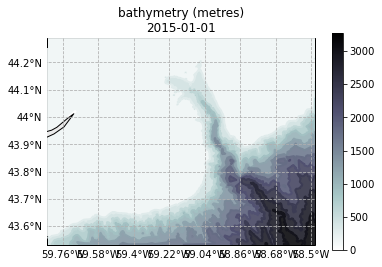

In [4]:
plot2D(var='bathy', source='chs', **bounds)

The transition from the light (shallow) to dark (deep) colors demarks the edge of the continental shelf. The Gully is seen running north south in the right side of the figure, while the eastern tip of Sable Island is visible near the left edge of the figure. 

WWIII provides windspeeds and waveheights with a resolution of only 0.5 degrees, so the data only have three distinct values in the domain we are considering here. We can visualize the data, as follows

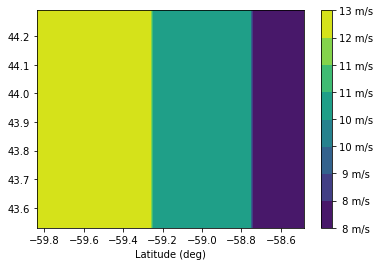

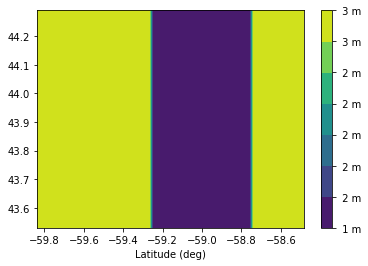

In [5]:
#plot2D(var='waveheight', source='wwiii', plot_wind='wwiii', **bounds)

x = np.linspace(-58.48, -59.84, 100)
y = np.linspace(43.53, 44.29, 100)
ws = gully.windspeed(lon=x,lat=y,grid=True)
wh = gully.waveheight(lon=x,lat=y,grid=True)
x, y = np.meshgrid(x, y)
# plot windspeed
plt.contourf(x,y,ws)
plt.xlabel('Longitude (deg)')
plt.xlabel('Latitude (deg)')
plt.colorbar(format='%2.0f m/s')
plt.show()
# plot waveheight
plt.contourf(x,y,wh)
plt.xlabel('Longitude (deg)')
plt.xlabel('Latitude (deg)')
plt.colorbar(format='%2.0f m')
plt.show()

## Source levels

The literature contains several parameterisations of the noise created by agitation of the sea surface. At present, the only parameterisation implemented in Kadlu is that of Kewley et al. (1990), which expresses the source level per surface area as a function of frequency and wind speed. For further details, see p. 114 Ocean Ambient Noise by Carey and Evans. However, you can easily implement your own parameterisations and use them with Kadlu, as we will demonstrate below.

Let us a take a moment to visualize the parameterisation of Kewley et al. for a few different frequencies,

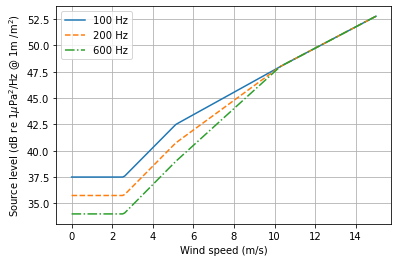

In [6]:
x = np.linspace(0,15,150)
y100 = kewley_sl_func(freq=100, windspeed=x)
y200 = kewley_sl_func(freq=200, windspeed=x)
y600 = kewley_sl_func(freq=600, windspeed=x)
plt.plot(x,y100, linestyle='-',  label='100 Hz')
plt.plot(x,y200, linestyle='--', label='200 Hz')
plt.plot(x,y600, linestyle='-.', label='600 Hz')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Source level (dB re 1$\mu$Pa$^2$/Hz @ 1m /m$^2$)')
plt.grid()
plt.legend()
plt.show()

The source level is seen to increase with increasing wind speed, while also exhibiting some dependence on frequency below 10 m/s.

We can easily implement our own source level parameterisation. For example, 

In [7]:
def new_sl_func(**kwargs):
    return 35.0 + 1.1 * kwargs['waveheight']

## Seafloor lithology

At present, Kadlu does not provide seafloor lithology data. Therefore, the acoustic properties of the seafloor must be specified manually. Here, we assume a sound speed of 1,700 m/s, a density of 1.5 g/cm$^3$ and an attenuation of 0.5 dB/$\lambda$.

In [8]:
# specify bottom acoustic properties
seafloor = {'sound_speed':1700,'density':1.5,'attenuation':0.5}

## Calculate ambient noise levels

We now will now use Kadlu's geophony function to compute the ambient noise levels at various locations in The Gully. 

For example, let us compute ambient noise level at 200 Hz at depths of 20 m and 300 m close to the center of the Gully (43.9$^{\circ}$N, -58.9$^{\circ}$W), using the source level parameterisation of Kewley et al. We will adopt a propagation range of 10 km, which means we are ignoring noise originating from a distance greater than 10 km.

In [9]:
ambient_noise = geophony(freq=200, depth=[30,300], lat=43.9, lon=-58.9, propagation_range=10,
         data_range=50, sl_func=kewley_sl_func, seafloor=seafloor, **data_sources, **bounds)

100%|██████████| 1333/1333 [00:39<00:00, 33.37it/s]


The geophony function returns a Python dictionary with following keys,

In [10]:
print(ambient_noise.keys())

dict_keys(['spl', 'lats', 'lons', 'x', 'y', 'z', 'bathy'])


We can inspect the sound-pressure levels (spl) and seafloor depth (bathy) as follows,

In [11]:
spl = np.squeeze(ambient_noise['spl'])
z = np.squeeze(ambient_noise['z'])
depth = ambient_noise['bathy'][0]

print('Sound pressure level:')
print(' *  {0:.0f} m:  {1:.1f} dB re 1 uPa^2/Hz @ 1m'.format(z[0],spl[0]))
print(' * {0:.0f} m:  {1:.1f} dB re 1 uPa^2/Hz @ 1m'.format(z[1],spl[1]))

print('\nSeafloor depth: {0:.1f} m'.format(depth))

Sound pressure level:
 *  30 m:  66.4 dB re 1 uPa^2/Hz @ 1m
 * 300 m:  67.3 dB re 1 uPa^2/Hz @ 1m

Seafloor depth: 600.5 m


To use our own source level parameterisation instead of that of Kewley et al., we only have to modify the sl_func argument,

In [12]:
ambient_noise = geophony(freq=200, depth=[30,300], lat=43.9, lon=-58.9, propagation_range=10,
         data_range=50, sl_func=new_sl_func, seafloor=seafloor, **data_sources, **bounds)

spl = np.squeeze(ambient_noise['spl'])
z = np.squeeze(ambient_noise['z'])
print('Sound pressure level:')
print(' *  {0:.0f} m:  {1:.1f} dB re 1 uPa^2/Hz @ 1m'.format(z[0],spl[0]))
print(' * {0:.0f} m:  {1:.1f} dB re 1 uPa^2/Hz @ 1m'.format(z[1],spl[1]))

100%|██████████| 1333/1333 [00:39<00:00, 33.67it/s]

Sound pressure level:
 *  30 m:  53.4 dB re 1 uPa^2/Hz @ 1m
 * 300 m:  54.3 dB re 1 uPa^2/Hz @ 1m


### Dependence on propagation range

In the above calculations, we somewhat arbitrarily used a propagation range of 10 km. We will now investigate the impact of this choice on the results

In [13]:
ranges = [0.125, 0.250, 0.500, 1, 2, 4, 8, 16, 24, 32, 40, 48, 64]

ambient_noise = []

for r in ranges:
    
    g = geophony(freq=200, depth=60, lat=43.9, lon=-58.9, propagation_range=r,
         data_range=20, sl_func=kewley_sl_func, seafloor=seafloor, **data_sources, **bounds)

    ambient_noise.append(g)

100%|██████████| 8533/8533 [05:28<00:00, 25.99it/s]


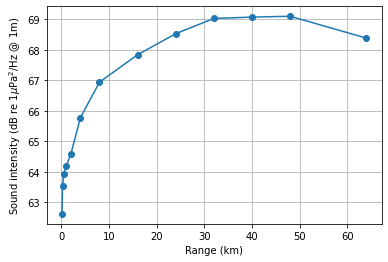

In [14]:
# plot the sound intensity vs. propagation range
spl=[]
for a in ambient_noise:
    spl.append(float(a['spl']))

plt.plot(ranges, spl, '-o')
plt.xlabel('Range (km)')
plt.ylabel('Sound intensity (dB re 1$\mu$Pa$^2$/Hz @ 1m)')
plt.grid()
plt.show()

As indicated by the graph, for this particular acoustic environment, a range of ~20 km is required to get convergent results at 200 Hz.